In [1]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import datetime
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing  
from pandas import DataFrame
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.ticker import MultipleLocator 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

In [2]:
path = os.getcwd().split('TianChi_IJCAI-17_footfall_prediction_code')[0]

#shop_info = pd.read_table(path+'dataset/shop_info.txt',names=['shop_id','city_name','location_id','per_pay','score','comment_cnt','shop_level','cate_1_name','cate_2_name','cate_3_name'],header=None,delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info = pd.read_table(path+'dataset/shop info with count.csv',delimiter=',',encoding='utf8',delim_whitespace=False,index_col=False)
shop_info.index = shop_info['shop_id'].tolist()

In [3]:
def dateRange(start, end):
    days = (datetime.datetime.strptime(end, "%Y-%m-%d") - datetime.datetime.strptime(start, "%Y-%m-%d")).days + 1
    return [datetime.datetime.strftime(datetime.datetime.strptime(start, "%Y-%m-%d") + datetime.timedelta(i), "%Y-%m-%d") for i in xrange(days)]

def draw_week_id(id,start_date='wk_0',end_date='wk_68',figsieze=(16,9)):
    shop_info.loc[id,start_date:end_date].T.plot(figsize=(16,9))
def draw_week_ids(ids,start_date='wk_0',end_date='wk_68',figsieze=(16,9)):
    shop_info.loc[ids,start_date:end_date].T.plot(figsize=(16,9))
def draw_ids(ids,dataset=shop_info,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):
    if by_week:
        xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
        dataset.loc[ids,start_date:end_date].T.plot(figsize=figsize,ax=ax)
    else: dataset.loc[ids,start_date:end_date].T.plot(figsize=figsize)
    plt.show()
def draw_ids_avg(ids,start_date='2015-07-01',end_date='2016-10-31',by_week=True,figsize=(70,10)):
    if by_week:
        xmajorLocator   = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    shop_info.loc[ids,start_date:end_date].mean(axis=0).plot(figsize=figsize)
    plt.show()
def draw_ids_diff(ids,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):  
    if by_week:
        xmajorLocator   = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    (shop_info.loc[ids[0],start_date:end_date]-shop_info.loc[ids[1],start_date:end_date]).plot(figsize=figsize)
def draw_id(id,start_date='2015-07-01',end_date='2016-10-31',by_week=False,figsize=(16,9)):
    if by_week:
        xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
        ax = plt.subplot(111) 
        ax.xaxis.set_major_locator(xmajorLocator)
    shop_info.loc[id,start_date:end_date].plot(legend=True,figsize=figsize)



# Data Cleaning

#### 填充最后4周出现单次零值状况

In [4]:
ids_zero_1_count_in_last_three_week = [513, 987, 1163, 524, 397, 18, 1556, 1688, 5, 1185, 1700, 1959, 683, 1715, 958, 480, 707, 459, 1486, 1831, 722, 735, 352, 363, 1661, 1918]
clean_day = dateRange('2016-10-11','2016-10-31')
clean_day.extend(dateRange('2016-09-20','2016-09-26'))
for day in clean_day:
    for id in ids_zero_1_count_in_last_three_week:
        if shop_info.loc[id,day] == 0:
            day_offset = (pd.to_datetime(day).date() - datetime.date(2016,10,11)).days % 7 
            rel_days = []
            for rel_day in dateRange('2016-10-11','2016-10-31'):
                if (pd.to_datetime(rel_day).date() - datetime.date(2016,10,11)).days % 7 == day_offset and rel_day != day:
                    rel_days.append(shop_info.loc[id,rel_day])
            rel_days = np.array(rel_days)
            shop_info.loc[id,day] = np.int64(rel_days.mean()+0.5)

In [5]:
days={}
for day in clean_day:
    offset = (pd.to_datetime(day).date() - datetime.date(2016,10,11)).days % 7
    if offset not in days:
        days[offset] = []
    days[offset].append(day)
     

In [6]:
ids_zero_morethan1_count_in_last_three_week = [2, 1707, 1925, 1418, 659, 1053, 1797, 1824, 547, 810, 432, 1459, 1462, 1464, 1465, 700, 191, 1858, 1993, 1109, 470,1243, 1380, 444, 1269, 632]

for id in ids_zero_morethan1_count_in_last_three_week:
    for day in clean_day:
        if shop_info.loc[id,day] == 0.0:
            #print '0'
            offset = (pd.to_datetime(day).date() - datetime.date(2016,10,11)).days % 7
            rel_days = []
            rel_days.extend(days[offset])
            #print rel_days
            for i in rel_days:
                if shop_info.loc[id,i] == 0.0:
                    rel_days.remove(i)
            #print shop_info.loc[id,rel_days].median()
            shop_info.loc[id,day] = shop_info.loc[id,rel_days].median()
        #else :print shop_info.loc[id,day]

# train

In [7]:
shop_info_num = shop_info.iloc[:,:10].copy()

In [8]:
weekA = shop_info.loc[:,'2016-09-20':'2016-09-26'].copy()
weekB = shop_info.loc[:,'2016-10-11':'2016-10-17'].copy()
weekC = shop_info.loc[:,'2016-10-18':'2016-10-24'].copy()
weekD = shop_info.loc[:,'2016-10-25':'2016-10-31'].copy()

In [9]:
'''  poly   degree=2     '''
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False)
train_x = weekA.join(weekB)                                    #train = weekA+ weekB + weekC
train_x = train_x.join(weekC)

In [10]:

def every_shop_open_ratio(start_day,end_day):
    Row = len(shop_info.index.tolist())
    row = 0
    Open_ratios = []
    while(row<Row):
        single_row = shop_info.iloc[row]
        single_row = single_row[start_day:end_day]
        open_ratio_ = (single_row>0).sum()/float((pd.to_datetime(end_day).date()-pd.to_datetime(start_day).date()).days+1)
        Open_ratios.append(round(open_ratio_,4))
        row = row+1
    Open_ratios = np.array(Open_ratios)
 
  
    mask = Open_ratios>=0
    df = DataFrame({'shop_id':(shop_info.shop_id)[mask].values,'open_ratio':Open_ratios[mask]},index=np.arange(1,2001))
    return  df   #返回大于threshold的shop_id,以及他们对应的开张比例


In [11]:
train_sum = train_x.sum(axis=1)
train_mean = train_x.mean(axis=1)
train_open_ratio_A = every_shop_open_ratio(start_day='2016-09-20',end_day='2016-09-26')
train_open_ratio_BC = every_shop_open_ratio(start_day='2016-10-11',end_day='2016-10-24')
train_open_ratio = (train_open_ratio_A.open_ratio + train_open_ratio_BC.open_ratio*2)/3
train_weekend = ['2016-09-24','2016-09-25','2016-10-15','2016-10-16','2016-10-22','2016-10-23']
train_ratio_wk = (train_x[train_weekend]).sum(axis=1)/(train_sum.replace(0,1))
train_std = train_x.std(axis=1)
train_max = train_x.max(axis=1)
train_min = train_x.min(axis=1)
train_median = train_x.median(axis=1)
train_mad = train_x.mad(axis=1)
train_var = train_x.var(axis=1) 

In [12]:
'''将多维数组转换为DataFrame'''
def transfrom_Arr_DF(arr,col_name = 'col_'):
    if(len(arr.shape)==1):
        df = DataFrame(arr,columns=['col_0'])
    else:
        df = DataFrame(arr,columns=[col_name+str(i) for i in range(arr.shape[1])],index=np.arange(1,len(arr)+1))
    return df

'''将一维数组转换为OHE码'''
def make_OHE(names):
    data = []
    for name in names:
        data.append([name])          
    enc = preprocessing.OneHotEncoder()
    enc.fit(data)
    OHE_data = enc.transform(data).toarray()  
    return OHE_data


In [13]:
shop_info_num['score'].replace(np.NaN,-1.0,inplace=True)
shop_info_num['comment_cnt'].replace(np.NaN,-1.0,inplace=True)
shop_info_num['cate_3_name'].replace(np.NaN,u'NaN',inplace=True)

In [14]:
city_name_usual=[u'上海',u'杭州',u'北京',u'广州',u'南京',u'武汉',u'深圳']
shop_info_num.loc[~shop_info_num['city_name'].isin(city_name_usual),'city_name'] = u'其他城市'
cate_1_name_usual=[u'美食',u'超市便利店']
shop_info_num.loc[~shop_info_num['cate_1_name'].isin(cate_1_name_usual),'cate_1_name'] = u'其他'
cate_2_name_usual=[u'快餐',u'超市',u'便利店',u'休闲茶饮',u'小吃',u'休闲食品',u'烘焙糕点',u'中餐',u'其他美食',u'火锅']
shop_info_num.loc[~shop_info_num['cate_2_name'].isin(cate_2_name_usual),'cate_2_name'] = u'其他'
cate_3_name_usual=[u'西式快餐',u'中式快餐',u'生鲜水果',u'奶茶',u'其它小吃',u'面包',u'饮品/甜点',u'面点',u'蛋糕']
shop_info_num.loc[~shop_info_num['cate_3_name'].isin(cate_3_name_usual),'cate_3_name'] = u'其他'


In [15]:
train_x = transfrom_Arr_DF(poly.fit_transform(train_x))

In [16]:

train_x['sumABCD'] = train_sum
train_x['open_ratio'] = train_open_ratio
train_x['ratio_wk'] = train_ratio_wk
train_x['meanABCD'] = train_mean
train_x['std'] = train_std
train_x['max'] = train_max
train_x['min'] = train_min
train_x['median'] = train_median
train_x['mad'] = train_mad
train_x['var'] = train_var

In [17]:
train_x = train_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
train_x = train_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [18]:
train_x = train_x.join(shop_info_num['location_id'])
train_x = train_x.join(shop_info_num['comment_cnt'])

In [19]:
#加入userview
user_view = pd.read_csv(path+'dataset/shop view separately.csv',index_col=0)

In [20]:
view_weekA = user_view.loc[:,'view_2016-09-20':'view_2016-09-26'].copy()
view_weekB = user_view.loc[:,'view_2016-10-11':'view_2016-10-17'].copy()
view_weekC = user_view.loc[:,'view_2016-10-18':'view_2016-10-24'].copy()
view_weekD = user_view.loc[:,'view_2016-10-25':'view_2016-10-31'].copy()

In [21]:
train_x = train_x.join(view_weekA)
train_x = train_x.join(view_weekB)
train_x = train_x.join(view_weekC)

In [22]:
#加入stable_day_

In [23]:
stable_wave_model = pd.read_csv('stable_wave_model.csv',index_col=0)

In [24]:
train_x = train_x.join(stable_wave_model)

In [25]:
#加入3周余弦相似度 与 近似商家wave

wk1=['2016-09-20','2016-09-26']
wk2=['2016-10-11','2016-10-17']
wk3=['2016-10-18','2016-10-24']

def cal_cos_sim_between(x,wka,wkb):
    wka_vec =  np.array(x[wka[0]:wka[1]].tolist())
    wkb_vec =  np.array(x[wkb[0]:wkb[1]].tolist())
    sim = wka_vec.dot(wkb_vec) / (np.sqrt(np.sum(np.square(wka_vec))) * np.sqrt(np.sum(np.square(wkb_vec))))
    return sim
train_x['cos_sim_between_wk_1_2'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk2),axis=1)
train_x['cos_sim_between_wk_2_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk2,wk3),axis=1)
train_x['cos_sim_between_wk_1_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk3),axis=1)

train_x['cos_sim_between_wk_1_2'].replace(np.NaN,0.0,inplace=True)
train_x['cos_sim_between_wk_2_3'].replace(np.NaN,0.0,inplace=True)
train_x['cos_sim_between_wk_1_3'].replace(np.NaN,0.0,inplace=True)

In [305]:
# 加入趋势特征

In [25]:
#加入天气

In [26]:
weather = pd.read_csv('shop_weather.csv',index_col=0)

In [27]:
train_x = train_x.join(weather.loc[:,'weather_2016-09-20':'weather_2016-10-31'])

In [71]:
train_x

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,wave_model2_2,wave_model2_3,wave_model2_4,wave_model2_5,wave_model2_6,wave_model2_7,ids_stable_period_1,ids_stable_period_2,ids_stable_period_3,ids_no_stable_period
1,223.0,206.0,220.0,241.0,272.0,240.0,225.0,254.0,239.0,228.0,...,233.500000,245.916667,257.750000,250.833333,234.416667,233.833333,1,0,0,0
2,77.0,82.0,71.0,71.0,96.0,121.0,67.0,0.0,0.0,0.0,...,96.250000,83.375000,90.125000,117.500000,123.000000,91.750000,1,0,0,0
3,62.0,59.0,55.0,79.0,112.0,83.0,88.0,68.0,63.0,56.0,...,71.142857,66.285714,73.428571,81.142857,84.571429,69.000000,0,1,0,0
4,74.0,101.0,102.0,98.0,203.0,199.0,91.0,86.0,113.0,71.0,...,115.428571,102.857143,114.857143,201.714286,220.142857,110.142857,0,1,0,0
5,277.0,272.0,309.0,182.0,179.0,4.0,305.0,223.0,218.0,230.0,...,269.000000,260.285714,217.142857,215.428571,197.142857,309.000000,0,0,1,0
6,77.0,68.0,74.0,73.0,67.0,89.0,83.0,83.0,91.0,90.0,...,46.600000,49.000000,62.400000,57.800000,58.600000,59.000000,0,1,0,0
7,105.0,116.0,105.0,141.0,168.0,180.0,109.0,136.0,93.0,128.0,...,152.200000,170.200000,184.800000,166.000000,212.000000,162.000000,1,0,0,0
8,62.0,65.0,57.0,71.0,69.0,73.0,55.0,81.0,63.0,65.0,...,106.500000,88.000000,95.250000,92.750000,86.000000,75.250000,0,1,0,0
9,238.0,214.0,229.0,242.0,288.0,324.0,212.0,225.0,202.0,192.0,...,205.520000,197.320000,203.760000,230.080000,238.040000,200.160000,1,0,0,0
10,73.0,104.0,69.0,76.0,73.0,89.0,80.0,108.0,111.0,73.0,...,66.000000,50.600000,52.600000,57.400000,72.400000,61.400000,0,0,1,0


#### train_y

In [28]:
train_y = weekD

### 检查 train_x train_y 是否符合要求 不包含NaN

In [30]:
 def fresh_ids():
    ids = range(1,2001)
    np.random.shuffle(ids)
    #print ids
    train_set_ids = ids[:1600]
    val_set_ids = ids[1600:]
    return train_set_ids,val_set_ids

In [ ]:
feature_list = [i for i in train_x.columns.tolist() if i not in ['col_'+str(num) for num in range(21,231)]]


## RF

In [32]:
#train_set_ids,val_set_ids = fresh_ids()
train_set_ids =range(1,1601)
val_set_ids = range(1601,2001)
RF = RandomForestRegressor(n_estimators=1600,
                            random_state=1,
                            n_jobs=-1,
                            min_samples_split=2,
                            min_samples_leaf=2,)
#print RF.score(train_x,train_y)
RF.fit(train_x.loc[train_set_ids,:],train_y.loc[train_set_ids,:])
print RF.score(train_x,train_y)
predict_val = pd.DataFrame(RF.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_val.loc[:,'predict_'+str(i)] = predict_val.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

train_score = 0.0
for id in val_set_ids:
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id-1,day] - predict_val.iloc[id-1,day]))/(train_y.iloc[id-1,day] + predict_val.iloc[id-1,day])/(7*400)
print train_score

0.939652943496
0.0814184858653


 train_score add location_id & comment_cnt
0.0770314034279
0.0779705913349
0.078948579937
0.0797655132658
0.0827867281122
0.0830453170442
0.0875721485457  -- 0.954111600465
0.0833575682115 
0.081675846769
0.0830629914982 
 加入 userview
0.0751307632343
0.0764668232205
0.0781205661011
 1600,400
0.0878128199044
 加入 三周余弦相似度（drop)
0.0878918600216
 加入 天气
0.0876963924706
0.0814184858653

## ET

In [31]:
#train_set_ids,val_set_ids = fresh_ids()
train_set_ids =range(1,1601)
val_set_ids = range(1601,2001)
ET = ExtraTreesRegressor(n_estimators=1600,
                           random_state=1,
                           n_jobs=-1,
                           min_samples_split=2,
                           min_samples_leaf=2,
                           max_depth=25,
                           max_features='auto')
ET.fit(train_x.loc[train_set_ids,:],train_y.loc[train_set_ids,:])

predict_val = pd.DataFrame(ET.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_val.loc[:,'predict_'+str(i)] = predict_val.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

train_score = 0.0
for id in val_set_ids:
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id-1,day] - predict_val.iloc[id-1,day]))/(train_y.iloc[id-1,day] + predict_val.iloc[id-1,day])/(7*400)
print train_score


0.0799747878751


#### train_score add location_id & comment_cnt

0.081000335966
0.0798722568859
0.0775547455471 

#### 加入 stable wave model max_features=290
0.0799956351718
0.0856649743061
0.0814708388275
0.0834221709742
#### 加入 userview
0.0800946904414
0.0820529531944
0.0817082217219
#### 1600,400
0.0867150894683
#### 加入 三周余弦相似度
0.0867362577526
####  max_features='auto'
0.0866585563586
####  天气
0.0865599468872
0.0799747878751


## 看看训练时的error都出在什么id上，是否要制定规则

In [113]:
ids_high_error = []
for id in range(2000):
    train_score = 0.0
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id,day] - predict_train.iloc[id,day]))/(train_y.iloc[id,day] + predict_train.iloc[id,day])/(7)
    #print id+1,train_score
    if train_score > 0.2:
        ids_high_error.append(id+1)
        

In [114]:
ids_high_error

[5,
 23,
 352,
 444,
 459,
 470,
 524,
 561,
 632,
 659,
 810,
 1058,
 1163,
 1185,
 1218,
 1243,
 1384,
 1407,
 1418,
 1526,
 1556,
 1650,
 1707,
 1716,
 1824,
 1856,
 1858,
 1918]

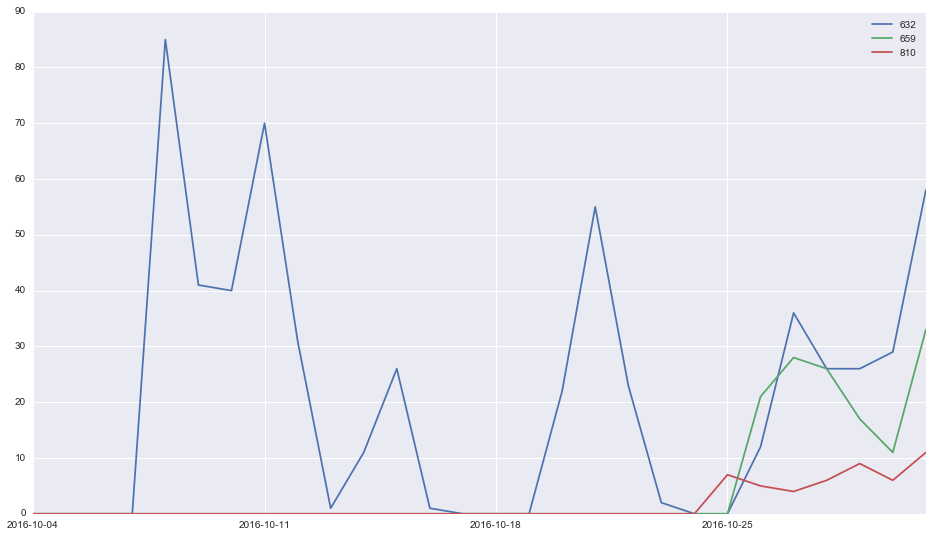

In [124]:
draw_ids(ids_high_error[8:11],dataset=shop_info,start_date = '2016-10-04',by_week=True)

In [99]:
train_predict_find_error = pd.DataFrame(ET.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])

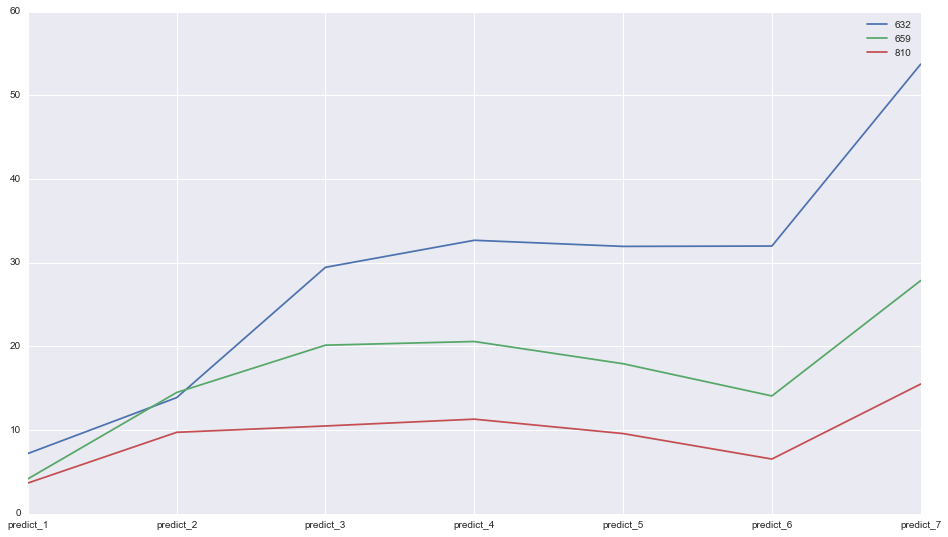

In [122]:
draw_ids(ids_high_error[8:11],dataset=train_predict_find_error ,start_date = 'predict_1',end_date='predict_7')

### 开始训练

## RF

In [33]:
RF = RandomForestRegressor(n_estimators=1600,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=None)
RF.fit(train_x,train_y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1600, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

## ET

In [34]:
ET = ExtraTreesRegressor(n_estimators=1600,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=2,max_depth=25,max_features=None)
ET.fit(train_x,train_y)


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=25,
          max_features=None, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=2, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=-1,
          oob_score=False, random_state=1, verbose=0, warm_start=False)

## GBDT

In [33]:
GBDT = []
for i in train_y.columns: 
    g = GradientBoostingRegressor(loss='huber')
    g.fit(train_x,train_y[i])
    GBDT.append(g)

In [35]:
RF.score(train_x,train_y)

0.96766230992273283

0.96566366376351054 max_depth = 25 / none n_estimators=1200
0.96595 n_estimators=1600
0.96602585097285765  加入 stable wave model
 加入 userview
0.96589687506866584
  加入 三周余弦相似度 （dropped)
0.96601672768808777 
 天气
0.96604498211593814
 单个零点修正
0.96652303038683252
  多
0.96766230992273283

In [36]:
ET.score(train_x,train_y)

0.98502505698992315

0.98402907280130347 no max_features
0.98404200338521919 max_features=270
0.98403486778744087  加入 stable wave model
0.98406360722194519 max_features=280
0.98408096361968167  max_features=290
 加入 userview
0.98408958618737985
 加入 三周余弦相似度 (dropped)
0.98407059228426352
max_features=300
0.98413913215600435
max_features=none
0.98419761469576117
 天气
0.98425916547308967
 单个零点修正
0.98445876781313557
  多
0.98502505698992315

In [36]:
np.mean([GBDT[n].score(train_x,train_y.iloc[:,n]) for n in range(len(GBDT))])

0.97033325758269917

0.96885431869673655
 单个零点修正
0.97033325758269917

### 查看比赛定义的训练成绩（仅1周的）

In [128]:
train_y

,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
1,255,172,226,257,251,281,180
2,82,97,83,96,96,115,80
3,80,61,68,103,102,104,67
4,90,104,55,110,215,196,115
5,302,1,0,215,203,291,239
6,97,100,117,133,109,118,86
7,128,115,111,128,165,162,81
8,70,68,72,49,70,71,35
9,210,197,245,205,291,283,212
10,77,114,85,84,99,93,121


In [37]:
predict_train = pd.DataFrame(RF.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_train.loc[:,'predict_'+str(i)] = predict_train.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

In [40]:
predict_train = pd.DataFrame(ET.predict(train_x),index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])
for i in range(1,8):
    predict_train.loc[:,'predict_'+str(i)] = predict_train.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))

In [41]:
train_score = 0.0
for id in range(2000):
    for day in range(7):
        train_score += float(np.fabs(train_y.iloc[id,day] - predict_train.iloc[id,day]))/(train_y.iloc[id,day] + predict_train.iloc[id,day])/(7*2000)
        
        

In [42]:
train_score

0.026370200198053632

In [ ]:
0.046128191132625
0.04603659731204112 (rf)
0.029443343537153256 (et)
0.046010419541393226 (rf) add weather
0.02912634783553982 (et)
0.043302722113275162(rf)
0.026370200198053632(et)

### feature importance

In [125]:
pd.concat((pd.DataFrame(train_x.columns, columns = ['variable']), 
           pd.DataFrame(RF.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('RF_feature_importance_.csv', sep=",", index = False)
pd.concat((pd.DataFrame(train_x.columns, columns = ['variable']), 
           pd.DataFrame(ET.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('ET_feature_importance_.csv', sep=",", index = False)

# offline test :  

In [184]:
train_score = 0.0
for id in range(2000):
    for day in range(7):
        train_score += float(np.fabs(weekD.iloc[id,day] - result.iloc[id,day]))/(weekD.iloc[id,day] + result.iloc[id,day])/(7*2000)
        
print train_score

IndexError: single positional indexer is out-of-bounds

# test

In [43]:
test_x = weekB.join(weekC)                                         #test = weekB + weekC + weekD 
test_x = test_x.join(weekD)


test_sum = test_x.sum(axis=1)
test_mean = test_x.mean(axis=1)
test_open_ratio = every_shop_open_ratio(start_day='2016-10-11',end_day='2016-10-31')
test_weekend = ['2016-10-15','2016-10-16','2016-10-22','2016-10-23','2016-10-29','2016-10-30']
test_ratio_wk = (test_x[test_weekend]).sum(axis=1)/(test_sum.replace(0,1))
test_std = test_x.std(axis=1)
test_max = test_x.max(axis=1)
test_min = test_x.min(axis=1)
test_median = test_x.median(axis=1)
test_mad = test_x.mad(axis=1)
test_var = test_x.var(axis=1)



In [44]:
test_x = transfrom_Arr_DF(poly.fit_transform(test_x))

test_x['sumABCD'] = test_sum
test_x['open_ratio'] = test_open_ratio.open_ratio
test_x['ratio_wk'] = test_ratio_wk
test_x['meanABCD'] = test_mean
test_x['std'] = test_std
test_x['max'] = test_max
test_x['min'] = test_min
test_x['median'] = test_median
test_x['mad'] = test_mad
test_x['var'] = test_var

In [45]:
test_x = test_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
test_x = test_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [46]:
test_x = test_x.join(shop_info_num['location_id'])
test_x = test_x.join(shop_info_num['comment_cnt'])

In [47]:


test_x = test_x.join(view_weekB)
test_x = test_x.join(view_weekC)
test_x = test_x.join(view_weekD)


In [48]:
test_x = test_x.join(stable_wave_model)

In [49]:
test_x = test_x.join(weather.loc[:,'weather_2016-10-11':'weather_2016-11-07'])

In [ ]:
"""
wk1=['2016-10-11','2016-10-17']
wk2=['2016-10-18','2016-10-24']
wk3=['2016-10-25','2016-10-31']
def cal_cos_sim_between(x,wka,wkb):
    wka_vec =  np.array(x[wka[0]:wka[1]].tolist())
    wkb_vec =  np.array(x[wkb[0]:wkb[1]].tolist())
    sim = wka_vec.dot(wkb_vec) / (np.sqrt(np.sum(np.square(wka_vec))) * np.sqrt(np.sum(np.square(wkb_vec))))
    return sim
test_x['cos_sim_between_wk_1_2'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk2),axis=1)
test_x['cos_sim_between_wk_2_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk2,wk3),axis=1)
test_x['cos_sim_between_wk_1_3'] = shop_info.apply(lambda x: cal_cos_sim_between(x,wk1,wk3),axis=1)

test_x['cos_sim_between_wk_1_2'].replace(np.NaN,0.0,inplace=True)
test_x['cos_sim_between_wk_2_3'].replace(np.NaN,0.0,inplace=True)
test_x['cos_sim_between_wk_1_3'].replace(np.NaN,0.0,inplace=True)
"""

## 检查是否columns是否相同

In [50]:
for i in range(len(train_x.columns.tolist())):
    if train_x.columns.tolist()[i] != test_x.columns.tolist()[i]:
        print train_x.columns.tolist()[i],test_x.columns.tolist()[i]

view_2016-09-20 view_2016-10-11
view_2016-09-21 view_2016-10-12
view_2016-09-22 view_2016-10-13
view_2016-09-23 view_2016-10-14
view_2016-09-24 view_2016-10-15
view_2016-09-25 view_2016-10-16
view_2016-09-26 view_2016-10-17
view_2016-10-11 view_2016-10-18
view_2016-10-12 view_2016-10-19
view_2016-10-13 view_2016-10-20
view_2016-10-14 view_2016-10-21
view_2016-10-15 view_2016-10-22
view_2016-10-16 view_2016-10-23
view_2016-10-17 view_2016-10-24
view_2016-10-18 view_2016-10-25
view_2016-10-19 view_2016-10-26
view_2016-10-20 view_2016-10-27
view_2016-10-21 view_2016-10-28
view_2016-10-22 view_2016-10-29
view_2016-10-23 view_2016-10-30
view_2016-10-24 view_2016-10-31
weather_2016-09-20 weather_2016-10-11
weather_2016-09-21 weather_2016-10-12
weather_2016-09-22 weather_2016-10-13
weather_2016-09-23 weather_2016-10-14
weather_2016-09-24 weather_2016-10-15
weather_2016-09-25 weather_2016-10-16
weather_2016-09-26 weather_2016-10-17
weather_2016-10-11 weather_2016-10-18
weather_2016-10-12 weath

In [51]:
result = ET.predict(test_x)
pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)]).to_csv('regression_prediction.csv', sep=",", index = True)

In [52]:
result = pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])

## 预测第二周 相比于第一周更换了天气特征～

In [53]:
test_x_2 = test_x.copy()

In [54]:
for i in ['weather_'+ date for date in dateRange('2016-10-11','2016-11-07')]:
    del test_x_2[i]

In [55]:
test_x_2 = test_x_2.join(weather.loc[:,'weather_2016-10-11':'weather_2016-10-31'])
test_x_2 = test_x_2.join(weather.loc[:,'weather_2016-11-08':'weather_2016-11-14'])

In [56]:
for i in range(len(test_x_2.columns.tolist())):
    if test_x_2.columns.tolist()[i] != test_x.columns.tolist()[i]:
        print test_x_2.columns.tolist()[i],test_x.columns.tolist()[i]

weather_2016-11-08 weather_2016-11-01
weather_2016-11-09 weather_2016-11-02
weather_2016-11-10 weather_2016-11-03
weather_2016-11-11 weather_2016-11-04
weather_2016-11-12 weather_2016-11-05
weather_2016-11-13 weather_2016-11-06
weather_2016-11-14 weather_2016-11-07


In [57]:
result2 = ET.predict(test_x_2)
result2 = pd.DataFrame(result2,index=range(1,2001),columns=['predict_'+str(i) for i in range(8,15)])


In [58]:
result2

,predict_8,predict_9,predict_10,predict_11,predict_12,predict_13,predict_14
1,218.234896,209.364583,225.879063,242.875417,254.890833,254.569479,204.232083
2,80.798542,76.510417,82.602500,91.606146,121.312917,119.327083,78.514271
3,70.129792,69.038750,72.134167,87.886875,116.531875,116.291042,71.091875
4,89.887083,85.053646,87.019688,117.265104,191.925104,195.520312,98.136250
5,227.917292,197.399063,217.018958,223.064271,226.108646,221.429896,208.276042
6,104.558125,104.829687,107.104167,116.649062,112.903646,112.225104,105.381875
7,113.495417,107.768646,119.142813,134.987604,171.082917,173.387500,111.382917
8,56.842500,57.682396,64.072812,63.745208,75.712292,72.926563,55.218958
9,214.104479,210.494479,229.757708,237.321354,252.497396,254.150104,202.188542
10,99.047813,95.481302,98.808958,100.170937,100.510937,101.491875,100.401250


# 双十一训练模型

In [59]:
double11_weekA = shop_info.loc[:,'2015-10-20':'2015-10-26'].copy()
double11_weekB = shop_info.loc[:,'2015-10-27':'2015-11-02'].copy()
double11_weekC = shop_info.loc[:,'2015-11-03':'2015-11-09'].copy()
double11_weekD = shop_info.loc[:,'2015-11-10':'2015-11-16'].copy()

In [60]:
'''  poly   degree=2     '''
poly = PolynomialFeatures(2,interaction_only=True,include_bias=False)
double11_train_x = double11_weekA.join(double11_weekB)                                    #train = weekA+ weekB + weekC
double11_train_x = double11_train_x.join(double11_weekC)

In [61]:
double11_train_sum = double11_train_x.sum(axis=1)
double11_train_mean = double11_train_x.mean(axis=1)
double11_train_open_ratio = every_shop_open_ratio(start_day='2015-10-20',end_day='2015-11-16')
double11_train_weekend = ['2015-10-24','2015-10-25','2015-10-31','2015-11-01','2015-11-07','2015-11-08']
double11_train_ratio_wk = (double11_train_x[double11_train_weekend]).sum(axis=1)/(double11_train_sum.replace(0,1))
double11_train_std = double11_train_x.std(axis=1)
double11_train_max = double11_train_x.max(axis=1)
double11_train_min = double11_train_x.min(axis=1)
double11_train_median = double11_train_x.median(axis=1)
double11_train_mad = double11_train_x.mad(axis=1)
double11_train_var = double11_train_x.var(axis=1) 

In [63]:
double11_train_x

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_221,col_222,col_223,col_224,col_225,col_226,col_227,col_228,col_229,col_230
1,262.0,271.0,260.0,240.0,291.0,286.0,264.0,295.0,310.0,212.0,...,213280.0,174096.0,142848.0,135904.0,150930.0,123840.0,117820.0,101088.0,96174.0,78912.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,434.0,405.0,261.0,0.0,0.0,2.0,1.0,0.0,0.0,121.0,...,7040.0,2530.0,3080.0,5390.0,1472.0,1792.0,3136.0,644.0,1127.0,1372.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,133.0,149.0,133.0,147.0,218.0,222.0,139.0,100.0,154.0,103.0,...,31439.0,20264.0,22052.0,17284.0,28696.0,31228.0,24476.0,20128.0,15776.0,17168.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10752.0,13344.0,11808.0,10944.0,15568.0,13776.0,12768.0,17097.0,15846.0,14022.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
double11_train_x = transfrom_Arr_DF(poly.fit_transform(double11_train_x))

In [64]:
double11_train_x['sumABCD'] = double11_train_sum
double11_train_x['open_ratio'] = double11_train_open_ratio.open_ratio
double11_train_x['ratio_wk'] = double11_train_ratio_wk
double11_train_x['meanABCD'] = double11_train_mean
double11_train_x['std'] = double11_train_std
double11_train_x['max'] = double11_train_max
double11_train_x['min'] = double11_train_min
double11_train_x['median'] = double11_train_median
double11_train_x['mad'] = double11_train_mad
double11_train_x['var'] = double11_train_var

In [65]:
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
double11_train_x = double11_train_x.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))

In [66]:
double11_train_x = double11_train_x.join(shop_info_num['location_id'])
double11_train_x = double11_train_x.join(shop_info_num['comment_cnt'])

In [67]:
double11_view_weekA = user_view.loc[:,'view_2015-10-20':'view_2015-10-26'].copy()
double11_view_weekB = user_view.loc[:,'view_2015-10-27':'view_2015-11-02'].copy()
double11_view_weekC = user_view.loc[:,'view_2015-11-03':'view_2015-11-09'].copy()
double11_view_weekD = user_view.loc[:,'view_2015-11-10':'view_2015-11-16'].copy()

In [68]:
double11_train_x = double11_train_x.join(double11_view_weekA)
double11_train_x = double11_train_x.join(double11_view_weekB)
double11_train_x = double11_train_x.join(double11_view_weekC)

In [69]:
double11_train_x = double11_train_x.join(stable_wave_model)

In [70]:
weather_double11 = pd.read_csv('shop_weather_double11.csv',index_col=0)
double11_train_x = double11_train_x.join(weather_double11.loc[:,'weather_2015-10-20':'weather_2015-11-16'])

#### 2015 双11 预测值

In [71]:
double11_predict  = ET.predict(double11_train_x)
double11_predict = pd.DataFrame(double11_predict,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)])

In [72]:
double11_predict

,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7
1,338.305104,334.813229,343.491771,353.994479,344.507187,351.246771,323.643958
2,8.304062,8.144896,7.014062,9.897604,10.273125,9.054479,13.100938
3,7.523854,7.664583,6.522812,8.179687,8.529375,7.384167,10.725208
4,8.168021,8.013646,6.893750,9.612500,9.996563,8.769479,12.634792
5,75.497917,70.056771,72.893958,82.372396,57.580729,54.328125,88.370833
6,7.765312,7.969062,6.803021,8.536042,9.085313,8.065937,11.151354
7,134.196250,127.110208,138.949479,150.150521,161.847500,163.386979,127.886458
8,7.603854,7.683854,6.572500,8.367812,8.870104,7.680000,10.837083
9,74.488542,71.274323,78.337813,91.421771,126.654375,125.164479,76.939062
10,7.807083,7.852812,6.730052,8.812448,9.136927,7.968542,11.675000


In [73]:
def cal_start_day(x):
    for day in dateRange('2015-07-01','2016-10-31'):
        if x[day]>0 :
            return day
    

shop_info['start_day'] = shop_info.apply(lambda x:cal_start_day(x),axis =1)

In [74]:
ids_2015_11_11 = []
def cal_2015_11_11(x):
    if pd.to_datetime(x['start_day']).date() < pd.to_datetime('2015-10-20').date():
        ids_2015_11_11.append(x['shop_id'])
    
shop_info.apply(lambda x: cal_2015_11_11(x),axis = 1)
print len(ids_2015_11_11)

642


In [75]:
ids_double11_checked = []
for id in ids_2015_11_11:
    zeroflag = 0
    for day in dateRange('2015-10-20','2015-11-16'):
        if shop_info.loc[id,day] == 0:
            zeroflag = 1
    if zeroflag == 0:
        ids_double11_checked.append(id)
print len(ids_double11_checked)

543


In [76]:
double11_tune_train = double11_predict.loc[ids_double11_checked,'predict_2':'predict_3'].copy()

In [77]:
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['score'],prefix='score_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_').loc[ids_double11_checked,:])
double11_tune_train = double11_tune_train.join(shop_info_num.loc[ids_double11_checked,'location_id'])
double11_tune_train = double11_tune_train.join(shop_info_num.loc[ids_double11_checked,'comment_cnt'])

In [78]:
double11_tune_train = double11_tune_train.join(shop_info.loc[ids_double11_checked,'2015-11-11':'2015-11-12'])

In [79]:
double11_tune_train['11_delta'] = double11_tune_train['2015-11-11'] - double11_tune_train['predict_2']
double11_tune_train['12_delta'] = double11_tune_train['2015-11-12'] - double11_tune_train['predict_3']

In [80]:
del double11_tune_train['2015-11-11']
del double11_tune_train['2015-11-12']

In [81]:
double11_tune_train_x = double11_tune_train.loc[:,:'comment_cnt']
double11_tune_train_y11 = double11_tune_train['11_delta']
double11_tune_train_y12 = double11_tune_train['12_delta']

### GridSearchCV

In [125]:
rf11 = RandomForestRegressor(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { 
    "min_samples_leaf" : [10,15], 
    "min_samples_split" : [2], 
    "n_estimators": [  700]}
gs1 = GridSearchCV(estimator=rf11, param_grid=param_grid, scoring=None, cv=4, n_jobs=-1)
gs1 = gs1.fit(double11_tune_train_x,double11_tune_train_y11)
print(gs1.best_score_)
print(gs1.best_params_)
print(gs1.best_estimator_)

0.266171501507
{'min_samples_split': 2, 'n_estimators': 700, 'min_samples_leaf': 10}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)


In [124]:
rf12 = RandomForestRegressor(max_features='auto', oob_score=True, random_state=1, n_jobs=-1)
param_grid = { 
    "min_samples_leaf" : [10,20], 
    "min_samples_split" : [2,4], 
    "n_estimators": [  700,900]}
gs2 = GridSearchCV(estimator=rf12, param_grid=param_grid, scoring=None, cv=4, n_jobs=-1)
gs2 = gs2.fit(double11_tune_train_x,double11_tune_train_y12)
print(gs2.best_score_)
print(gs2.best_params_)
print(gs2.best_estimator_)

0.0550438570898
{'min_samples_split': 2, 'n_estimators': 700, 'min_samples_leaf': 10}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=True, random_state=1,
           verbose=0, warm_start=False)


In [82]:
RF11 = RandomForestRegressor(n_estimators=700,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=10,max_depth=None)
RF12 = RandomForestRegressor(n_estimators=700,random_state=1,n_jobs=-1,min_samples_split=2,min_samples_leaf=10,max_depth=None)

RF11.fit(double11_tune_train_x,double11_tune_train_y11)
RF12.fit(double11_tune_train_x,double11_tune_train_y12)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=700, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [132]:
pd.concat((pd.DataFrame(double11_tune_train_x.columns, columns = ['variable']), 
           pd.DataFrame(RF11.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('double11_RF11_feature_importance_.csv', sep=",", index = False)
pd.concat((pd.DataFrame(double11_tune_train_x.columns, columns = ['variable']), 
           pd.DataFrame(RF12.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False).to_csv('double11_RF12_feature_importance_.csv', sep=",", index = False)


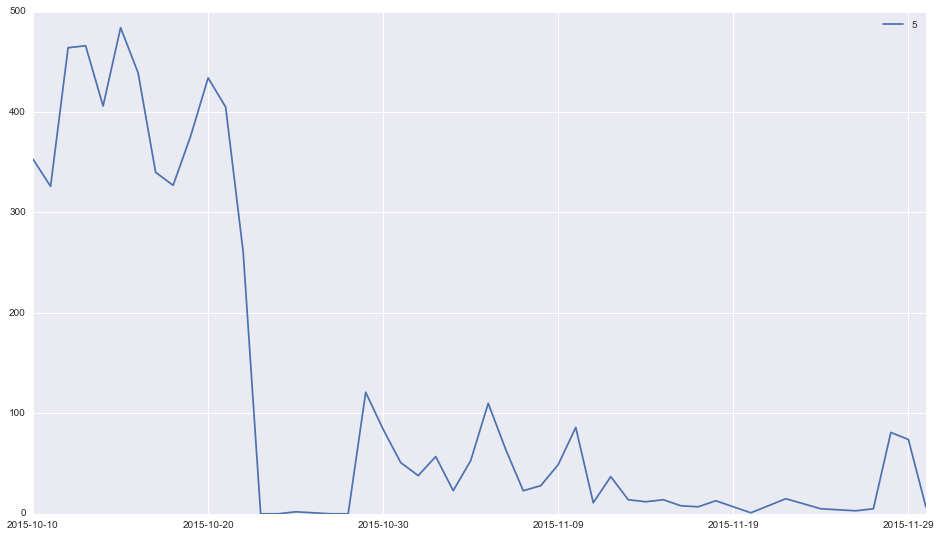

In [83]:
draw_id(5,start_date='2015-10-10',end_date='2015-11-30')

### 11.11 boost

In [85]:
double11_tune_test = result2.loc[:,'predict_11':'predict_12'].copy()

double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['shop_level'],prefix='shop_level_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['score'],prefix='score_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['per_pay'],prefix='per_pay_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['city_name'],prefix='city_name_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['cate_1_name'],prefix='cate_1_name_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['cate_2_name'],prefix='cate_2_name_'))
double11_tune_test = double11_tune_test.join(pd.get_dummies(shop_info_num['cate_3_name'],prefix='cate_3_name_'))
double11_tune_test = double11_tune_test.join(shop_info_num['location_id'])
double11_tune_test = double11_tune_test.join(shop_info_num['comment_cnt'])

In [86]:
double11_tune_test

,predict_11,predict_12,shop_level__0,shop_level__1,shop_level__2,score__-1.0,score__0.0,score__1.0,score__2.0,score__3.0,...,cate_3_name__其它小吃,cate_3_name__奶茶,cate_3_name__生鲜水果,cate_3_name__蛋糕,cate_3_name__西式快餐,cate_3_name__面包,cate_3_name__面点,cate_3_name__饮品/甜点,location_id,comment_cnt
1,242.875417,254.890833,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,885,12.0
2,91.606146,121.312917,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64,-1.0
3,87.886875,116.531875,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,774,2.0
4,117.265104,191.925104,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380,-1.0
5,223.064271,226.108646,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,263,2.0
6,116.649062,112.903646,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1139,1.0
7,134.987604,171.082917,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,145,9.0
8,63.745208,75.712292,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,234,1.0
9,237.321354,252.497396,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1120,0.0
10,100.170937,100.510937,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98,-1.0


In [87]:
RF11.predict(double11_tune_test)

array([ 76.73136396,  16.85663403, -16.64509873, ..., -46.3241646 ,
        -2.49737507, -24.14915281])

In [88]:
double11_boost = pd.DataFrame(RF11.predict(double11_tune_test),index=range(1,2001),columns=['11boost']).join(pd.DataFrame(RF12.predict(double11_tune_test),index=range(1,2001),columns=['12boost']))

In [89]:
double11_boost

,11boost,12boost
1,76.731364,50.616560
2,16.856634,-4.687784
3,-16.645099,-32.326204
4,31.445492,-3.015634
5,-36.457918,-50.763656
6,-36.851630,-29.436441
7,46.638488,-2.404739
8,-8.507406,-19.080851
9,10.810766,-31.036243
10,-3.557750,-22.445567


In [90]:
result2.loc[:,'predict_11'] += 0.1*double11_boost['11boost']
result2.loc[:,'predict_12'] += 0.1*double11_boost['12boost']

## 结果可视化

In [91]:
shop_info = shop_info.join(pd.DataFrame(result,index=range(1,2001),columns=['predict_'+str(i) for i in range(1,8)]))
shop_info = shop_info.join(pd.DataFrame(result2,index=range(1,2001),columns=['predict_'+str(i) for i in range(8,15)]))

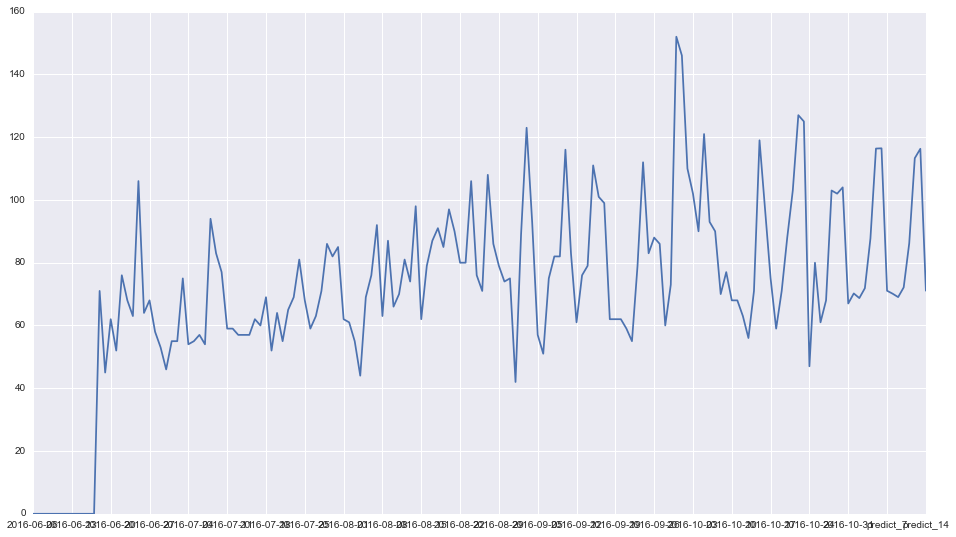

In [95]:

list_result = dateRange('2016-06-06','2016-10-31')
for i in range(1,15):
    list_result.append('predict_'+str(i))

xmajorLocator = MultipleLocator(7) #将x轴次刻度标签设置为7的倍数
ax = plt.subplot(111) 
ax.xaxis.set_major_locator(xmajorLocator)
shop_info.loc[3,list_result].T.plot(figsize=(16,9),ax=ax)

In [48]:

#  占个格子 &&  cal avg sales count each day
total_day = pd.to_datetime('2016-11-01').date()-pd.to_datetime('2015-07-01').date() 
total_day = total_day.days
total_week = total_day / 7  # 69个
start_day = pd.to_datetime('2016-11-01').date() - datetime.timedelta(total_week*7)
#print start_day
for week_number in range(total_week): # 0~68
    start_day_of_week = start_day +  datetime.timedelta(week_number*7) 
    end_day_of_week = start_day_of_week + datetime.timedelta(6)
    start_day_of_week =   start_day_of_week.strftime("%Y-%m-%d")
    end_day_of_week = end_day_of_week.strftime("%Y-%m-%d")
    print start_day_of_week,end_day_of_week
    shop_info['wk_'+str(week_number)] = shop_info.loc[:,start_day_of_week:end_day_of_week].mean(axis=1)

2015-07-07 2015-07-13
2015-07-14 2015-07-20
2015-07-21 2015-07-27
2015-07-28 2015-08-03
2015-08-04 2015-08-10
2015-08-11 2015-08-17
2015-08-18 2015-08-24
2015-08-25 2015-08-31
2015-09-01 2015-09-07
2015-09-08 2015-09-14
2015-09-15 2015-09-21
2015-09-22 2015-09-28
2015-09-29 2015-10-05
2015-10-06 2015-10-12
2015-10-13 2015-10-19
2015-10-20 2015-10-26
2015-10-27 2015-11-02
2015-11-03 2015-11-09
2015-11-10 2015-11-16
2015-11-17 2015-11-23
2015-11-24 2015-11-30
2015-12-01 2015-12-07
2015-12-08 2015-12-14
2015-12-15 2015-12-21
2015-12-22 2015-12-28
2015-12-29 2016-01-04
2016-01-05 2016-01-11
2016-01-12 2016-01-18
2016-01-19 2016-01-25
2016-01-26 2016-02-01
2016-02-02 2016-02-08
2016-02-09 2016-02-15
2016-02-16 2016-02-22
2016-02-23 2016-02-29
2016-03-01 2016-03-07
2016-03-08 2016-03-14
2016-03-15 2016-03-21
2016-03-22 2016-03-28
2016-03-29 2016-04-04
2016-04-05 2016-04-11
2016-04-12 2016-04-18
2016-04-19 2016-04-25
2016-04-26 2016-05-02
2016-05-03 2016-05-09
2016-05-10 2016-05-16
2016-05-17

In [49]:
shop_info['result_avg'] = shop_info.loc[: ,['predict_'+str(i) for i in range(1,8)]].mean(axis=1)

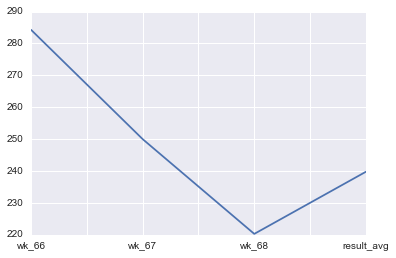

In [50]:
shop_info.loc[39,'wk_66':'result_avg'].plot()

In [ ]:
## 保存结果

In [96]:
result_total = result.join(result2)

In [97]:
for i in range(1,15):
    result_total.loc[:,'predict_'+str(i)] = result_total.loc[:,'predict_'+str(i)].apply(lambda x : int(x+0.5))
    

In [99]:
## 检查是否每个都大于0
for id in range(2000):
    for day in range(14):
        if result_total.iloc[id,day] <= 0 : print 'error',result_total.iloc[id,day]
    

In [98]:
result_total.to_csv('regression_prediction_two_week(final).csv', sep=",", index = True)